In [46]:
import torch
import joblib
import pandas
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [47]:
dataset = joblib.load('oht_dataframe.pkl')
X,y = dataset.drop(columns='state'),dataset['state']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=False)
# X_test,y_test = X_test.reset_index(drop=True),y_test.reset_index(drop=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
y_train.value_counts(normalize=True)

(41334, 12) (17715, 12) (41334,) (17715,)


state
0    0.488532
2    0.216142
1    0.214763
3    0.080563
Name: proportion, dtype: float64

In [48]:
class MultimodalDataset(Dataset):
    """사용자 정의 멀티모달 데이터셋"""
    def __init__(self,X:pandas.DataFrame,y:pandas.Series):
        """필요한 데이터를 이곳에서 선언
        Parameter:
        X: 열화상 이미지와 센서데이터의 데이터 프레임
        y: 정답 데이터의
        """
        self.X = X
        self.y = y
    def __getitem__(self, index):
        """열화상 이미지 [1,120,160]크기와 센서 데이터 11개의 칼럼 그리고 이에 해당하는 정답 데이터 반환"""
        image = torch.tensor(np.load(self.X.iloc[index]['filenames']),dtype=torch.float32).unsqueeze(0)
        sensor_features = self.X.drop(columns=['filenames'])
        sensor_features = torch.tensor(sensor_features.iloc[index].values,dtype=torch.float32)
        label = int(self.y.iloc[index]) # 나중에 학습하는데 있어서 느려지게하는 요인이면 데이터 프레임 자체에서 변경함함
        return image, sensor_features, label
    
    def __len__(self):
        return len(self.X)

train_dataset = MultimodalDataset(X_train,y_train)
test_dataset = MultimodalDataset(X_test,y_test)

train_image,train_sensor_features,train_label = train_dataset[0]
test_image,test_sensor_features,test_label = test_dataset[0]

print(len(train_dataset))
print(train_image.shape,train_sensor_features.shape,train_label)

print(len(test_dataset))
print(test_image.shape,test_sensor_features.shape,test_label)

41334
torch.Size([1, 120, 160]) torch.Size([11]) 0
17715
torch.Size([1, 120, 160]) torch.Size([11]) 0


In [49]:
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=False)
print(len(train_dataloader),len(test_dataloader))

2584 1108


In [7]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        # Transformer 설정
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        # Patch embedding: 채널을 1로 설정
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        # 포지셔널 임베딩
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # x: [batch_size, 1, img_dim_h, img_dim_w]
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding  # Positional embedding 추가
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]

class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output

class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h,img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        # Feature extraction
        visual_features = self.vit(images)  # [batch_size, embed_dim]
        aux_features = self.soft_label_encoder(aux_data)  # [batch_size, embed_dim]

        # Cross attention
        visual_features = visual_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        aux_features = aux_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)

        # Classification
        output = self.classifier(integrated_features)  # [batch_size, num_classes]
        return output
    
img_dim_h = 120  # 열화상 이미지 세로 크기
img_dim_w = 160  # 열화상 이미지 가로 크기
patch_size = 16
embed_dim = 128
num_heads = 4
depth = 6
aux_input_dim = 11  # 보조 데이터 차원 (예: 온도, 습도 등)
num_classes = 4  # 0:정상,1:관심,2:주의,3:위험
model = ConditionClassifier(img_dim_w, img_dim_h, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes)

In [8]:
from tqdm.auto import tqdm
def train_step(model:torch.nn.Module,
               train_loader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device:torch.device='cuda'):
    model.train()
    # 모델도 GPU 환경으로 보내기 (모델 학습시 GPU 학습 가속화)
    model = model.to(device)
    train_loss, train_acc = 0.0, 0.0
    for batch_images,batch_features,target in tqdm(train_loader):
        # GPU 상으로 데이터 보내기 (모델 학습시 GPU 학습 가속화)
        batch_images,batch_features,target = batch_images.to(device),batch_features.to(device),target.to(device)
        # 데이터 -> 모델 입력 
        y_pred = model(batch_images,batch_features)
        # 로스값 계산
        loss = loss_fn(y_pred,target)
        train_loss += loss.item()
        # 최적화 기울기 초기화
        optimizer.zero_grad()
        # 역전파 Loss Backward
        loss.backward()
        # Optimizer Step 가중치 업데이트
        optimizer.step()
        # 정확도 계산
        y_pred_class = torch.argmax(F.softmax(y_pred,dim=1),dim=1)
        train_acc += ((y_pred_class==target).sum().item()/len(y_pred))
    train_loss,train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
    return train_loss,train_acc

def test_step(model:torch.nn.Module,
              test_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device='cuda'):
    # 평가 모드
    model.eval()
    test_loss,test_acc = 0.0, 0.0
    # 추론 모드
    with torch.inference_mode():
        for batch_images,batch_features,target in tqdm(test_loader):
            # GPU 상으로 데이터 보내기 (모델 학습시 GPU 학습 가속화)
            batch_images,batch_features,target = batch_images.to(device),batch_features.to(device),target.to(device)
            
            # 데이터 -> 모델 입력 
            test_pred_logits = model(batch_images,batch_features)
            
            # 로스 계산
            loss = loss_fn(test_pred_logits,target)
            test_loss += loss.item()
            
            # 정확도 계산
            test_pred_class = torch.argmax(F.softmax(test_pred_logits,dim=1),dim=1)
            test_acc += ((test_pred_class==target).sum().item()/len(test_pred_logits))
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader)        
    return test_loss,test_acc

c:\Users\hyssk\anaconda3\envs\pytorch_cuda_11_8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from torch.optim import Adam
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets)
        pt = torch.exp(-ce_loss)  # 예측 확률
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

focal_loss = FocalLoss(alpha=0.25, gamma=2) # Focal Loss 파라미터 초기화
optimizer = Adam(model.parameters(),lr=0.0001)

In [15]:
EPOCHS = 15
results = {'train_acc':[],'train_loss':[],'test_acc':[],'test_loss':[]}
maximum_test_acc = 0

for epoch in range(1,EPOCHS+1,1):
    print(f"THIS IS {epoch} times")
    train_loss,train_acc = train_step(model,train_dataloader,focal_loss,optimizer)
    results['train_acc'].append(train_acc)
    results['train_loss'].append(train_loss)
    print(f'train_loss:{train_loss} | train_acc:{train_acc}')
    
    test_loss,test_acc = test_step(model,test_dataloader,focal_loss)
    results['test_acc'].append(test_acc)
    results['test_loss'].append(test_loss)
    
    print(f'test_loss:{test_loss} | test_acc:{test_acc}')
    
    if maximum_test_acc < test_acc:
        maximum_test_acc = test_acc
        torch.save(model,'OHT_Best_Model.pth')
        print(f'Best Model was saved. | test_acc : {test_acc}')
    else:
        pass
    print('-'*100)

THIS IS 1 times


100%|██████████| 2584/2584 [08:19<00:00,  5.18it/s]


train_loss:0.02357497589942938 | train_acc:0.8660990712074303


100%|██████████| 1108/1108 [02:52<00:00,  6.42it/s]


test_loss:0.024310357633206707 | test_acc:0.8801895306859205
Best Model was saved. | test_acc : 0.8801895306859205
----------------------------------------------------------------------------------------------------
THIS IS 2 times


  3%|▎         | 70/2584 [00:15<09:05,  4.61it/s]


KeyboardInterrupt: 

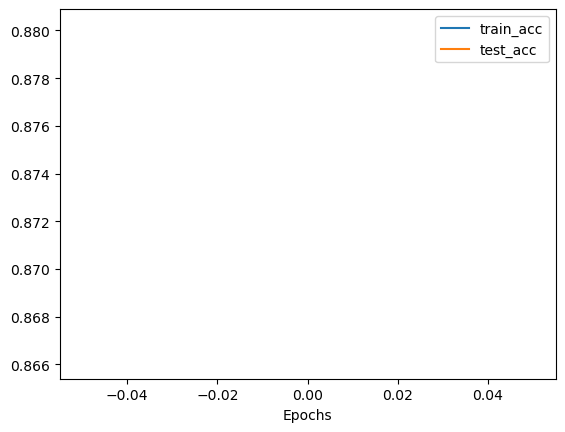

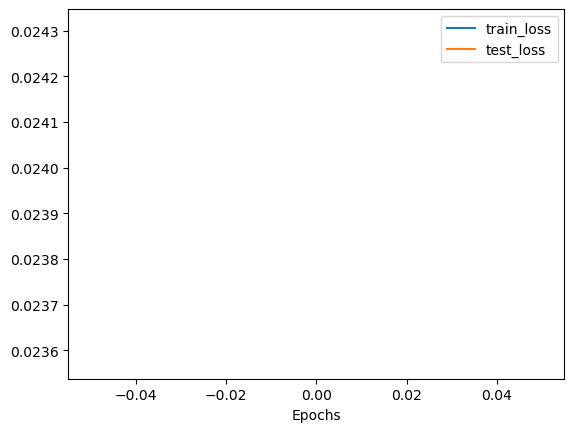

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results['train_acc'],label='train_acc')
plt.plot(results['test_acc'],label='test_acc')
plt.legend()
plt.xlabel('Epochs')
plt.show()

plt.figure()
plt.plot(results['train_loss'],label='train_loss')
plt.plot(results['test_loss'],label='test_loss')
plt.legend()
plt.xlabel('Epochs')
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
model.eval()
# test_dataloader = iter(test_dataloader)
# images, features, targets = next(test_dataloader)
# print(images.shape,features.shape)

# images, features, targets = images.to('cuda'), features.to('cuda'), targets.to('cuda')
with torch.inference_mode():
    # print(test_step(model,test_dataloader,focal_loss))
    print(torch.argmax(F.softmax(model(images,features),dim=1),dim=1))

tensor([3, 3, 3], device='cuda:0')


In [50]:
y_true = torch.tensor([]).to(device='cuda')
y_pred = torch.tensor([]).to(device='cuda')

with torch.inference_mode():
    model.eval()
    for images,features,targets in test_dataloader:
        images, features, targets = images.to('cuda'), features.to('cuda'), targets.to('cuda')
        predictions = torch.argmax(F.softmax(model(images,features),dim=1),dim=1)
        y_pred = torch.cat((y_pred, predictions))
        y_true = torch.cat((y_true, targets))
print(y_pred)
print(y_true)

tensor([0., 0., 0.,  ..., 3., 3., 3.], device='cuda:0')
tensor([0., 0., 0.,  ..., 3., 3., 3.], device='cuda:0')


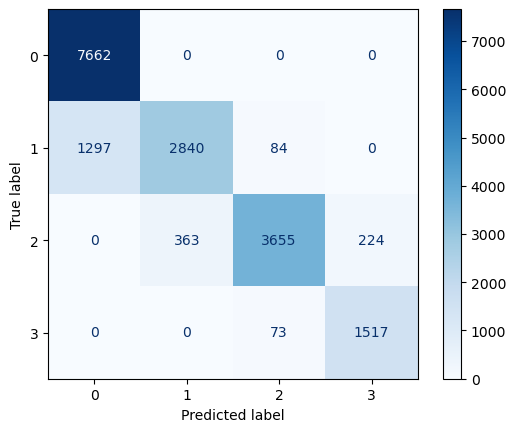

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_true = y_true.cpu()
y_pred = y_pred.cpu()
cm = confusion_matrix(y_true,y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()

In [55]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      7662
         1.0       0.89      0.67      0.77      4221
         2.0       0.96      0.86      0.91      4242
         3.0       0.87      0.95      0.91      1590

    accuracy                           0.88     17715
   macro avg       0.89      0.87      0.88     17715
weighted avg       0.89      0.88      0.88     17715

